In [148]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrix
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, r2_score, PredictionErrorDisplay
from sklearn.linear_model import LinearRegression

In [149]:
ames = pd.read_csv('ames.csv', index_col=0)
ames.head(10)

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,SaleType,SaleCondition,TotalBath,TotalSF,HQSF,yrsbtwn,BedxBath,RoomsxBath,FireplaceYN,TotalPorchSF
1,909176150,856,126000,30,RL,58.77,7890,Pave,No Alley,Reg,...,WD,Normal,2.00,1712.00,1712.00,11,4.00,8.00,1,166
2,905476230,1049,139500,120,RL,42.00,4235,Pave,No Alley,Reg,...,WD,Normal,3.00,2098.00,2098.00,0,6.00,15.00,0,105
3,911128020,1001,124900,30,C (all),60.00,6060,Pave,No Alley,Reg,...,WD,Normal,1.00,1838.00,1838.00,77,2.00,5.00,0,282
4,535377150,1039,114000,70,RL,80.00,8146,Pave,No Alley,Reg,...,WD,Normal,1.00,1444.00,1444.00,103,2.00,6.00,0,279
5,534177230,1665,227000,60,RL,70.00,8400,Pave,No Alley,Reg,...,WD,Normal,3.50,2475.00,2475.00,0,10.50,21.00,0,45
6,908128060,1922,198500,85,RL,64.00,7301,Pave,No Alley,Reg,...,ConLD,Normal,3.00,1922.00,1922.00,0,12.00,21.00,1,177
7,902135020,936,93000,20,RM,60.00,6000,Pave,Pave,Reg,...,WD,Normal,1.00,1872.00,1872.00,0,2.00,4.00,0,144
8,528228540,1246,187687,20,RL,53.00,3710,Pave,No Alley,Reg,...,New,Partial,2.00,2392.00,2392.00,1,4.00,10.00,1,124
9,923426010,889,137500,20,RL,74.00,12395,Pave,No Alley,Reg,...,WD,Normal,1.00,1753.00,1753.00,0,3.00,6.00,0,0
10,908186050,1072,140000,180,RM,35.00,3675,Pave,No Alley,Reg,...,WD,Normal,2.00,1619.00,1619.00,0,4.00,10.00,0,44


### I. SLR with Train-Test Split: Run a linear regression on every column vs SalePrice and Report R^2, beta, intercept

In [150]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
pd.set_option('display.max_rows', 100)

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

y = ames[['SalePrice']]
X = ames.drop(columns = ['PID', 'SalePrice'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 0)

cat_cols = [i for i, col in enumerate(X_train.columns) if X_train[col].dtype == 'object']

encoder = OneHotEncoder(drop = 'first', handle_unknown = 'ignore')

results_list = []



for col in range(X_train.shape[1]):
    df_list = []
    
    if col in cat_cols:
        
        transformed_col = encoder.fit_transform(X_train.iloc[:, [col]])
    else:
        transformed_col = X_train.iloc[:, [col]]
    
    X_feature_train, X_feature_test, Y_train, Y_test = train_test_split(transformed_col, y_train, test_size = .2, random_state = 0)
    
    model = LinearRegression()
    model.fit(X_feature_train, Y_train)
    
    Y_pred = model.predict(X_feature_test)
    
    r2 = r2_score(Y_test, Y_pred)
    
    col_name = X_train.columns[col]
    
    df_list.append(col_name)
    
    df_list.append(r2)
    
    coef_flat = model.coef_.flatten().tolist()
    
    df_list.append(coef_flat)
    
    df_list.append(model.intercept_[0])

    results_list.append(df_list)

results_list = sorted(results_list, key=lambda x: x[1], reverse = True)

slr_detailed = pd.DataFrame(results_list, columns = ['feature', 'r2', 'betas', 'intercept'])

slr_detailed

,feature,r2,betas,intercept
0,HQSF,0.70,[77.21613680254939],-17459.36
1,TotalSF,0.70,[77.06908555009133],-17447.81
2,OverallQual,0.60,[42212.01016287305],-78116.74
3,Neighborhood,0.55,"[-49594.61527449699, -93844.61512463707, -7114...",198094.62
4,ExterQual,0.53,"[-276953.8389355737, -137450.13939144128, -219...",365030.31
5,GrLivArea,0.53,[105.44839060497975],20199.56
6,RoomsxBath,0.48,[6446.430484928959],83197.43
7,KitchenQual,0.47,"[-207785.32986111107, -108085.2447584921, 0.0,...",316937.55
8,BsmtQual,0.45,"[-207762.92721469887, -116473.39858224175, -20...",316043.47
9,TotalBsmtSF,0.44,[114.90786045489672],57672.45


#### 'Back of Envelope' Interpretation

In [151]:
slr_detailed.loc[0,:]
#By just plotting high quality square footage at a rate of $77.21/ft^2, you can explain about 70% of the saleprices.
#The intercept is a construct for the regression. (226 ft^2 before you're paying $0!)

feature                     HQSF
r2                          0.70
betas        [77.21613680254939]
intercept              -17459.36
Name: 0, dtype: object

In [152]:
slr_detailed.loc[2,:]

feature              OverallQual
r2                          0.60
betas        [42212.01016287305]
intercept              -78116.74
Name: 2, dtype: object

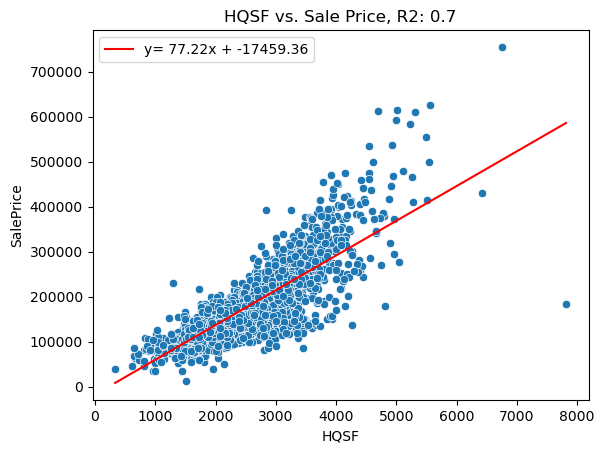

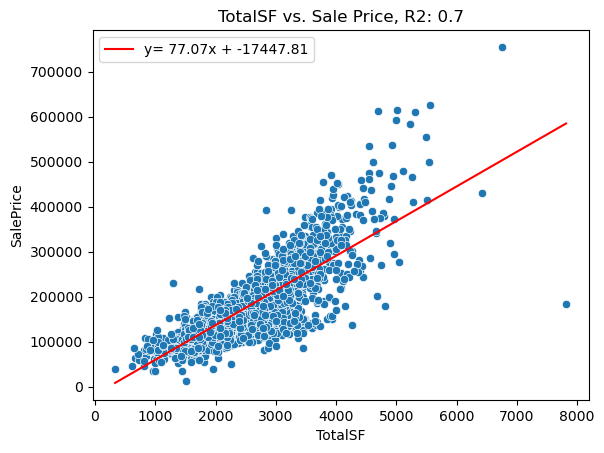

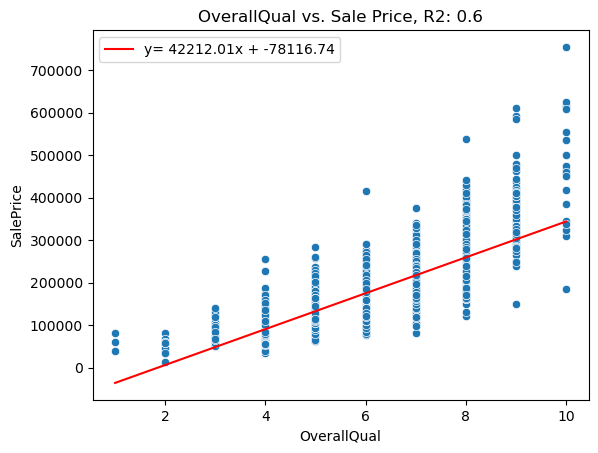

In [153]:
def numeric_slr_plot(myseries, df = ames):
    colname = myseries[0]
    R2 = myseries[1]
    m = round(myseries[2][0], 2)
    b = round(myseries[3], 2)
    
    mydf = df.loc[:, [colname, 'SalePrice']]
    sns.scatterplot(data = mydf, x = colname, y = 'SalePrice')
    x_vals = np.linspace(df[[colname]].min(), df[[colname]].max(), 100)
    y_vals = m*x_vals + b
    plt.plot(x_vals, y_vals, color='red', label= f'y= {m}x + {b}')
    plt.title(f"{colname} vs. Sale Price, R2: {round(R2, 2)}")
    plt.legend()
    plt.show()

#Plot numeric variables vs. SalePrice w/ regression line (try 0, 1, 2)
numeric_slr_plot(slr_detailed.loc[0,:], ames)
numeric_slr_plot(slr_detailed.loc[1,:], ames)
numeric_slr_plot(slr_detailed.loc[2,:], ames)

In [154]:
slr_detailed.loc[3, 'betas']
#df.loc[3, :]
#Neighborhood coefficients--- which of these are significant/have robust enough # of homes?
#We are talking about almost $200K difference here. Some of these neighborhoods only have 1 or 2 homes, and the
#p-values associated with each will certainly not be significant.

[-49594.61527449699,
 -93844.61512463707,
 -71144.97577890745,
 9963.298008158705,
 -4535.2038629650315,
 2105.3859319617577,
 -65968.19086601882,
 -9985.172831017999,
 -6844.615314050307,
 81905.38464371194,
 -90449.01934576307,
 -61094.61537672886,
 -97603.3107150738,
 -37096.696599377894,
 -53352.84143073371,
 -55833.90090578082,
 -5531.389287262127,
 125547.43092849312,
 108626.12736956871,
 -72266.11711478647,
 -65502.614950815376,
 -58583.821069452584,
 -7630.494550128224,
 27248.985002569185,
 111585.24206482976,
 50720.567006123754,
 53558.71815793986]

### II. SLR with Cross-Validation:
Run a linear regression on every column vs SalePrice and Report R^2.

In [155]:
from sklearn.model_selection import cross_val_score
pd.options.display.float_format = '{:.4f}'.format

y = ames[['SalePrice']]
X = ames.drop(columns = ['PID', 'SalePrice'])

cat_cols = [i for i, col in enumerate(X.columns) if X[col].dtype == 'object']

encoder = OneHotEncoder(drop = 'first', handle_unknown = 'ignore')

big_list = []

for col in range(X.shape[1]):
    
    if col in cat_cols:
        
        transformed_col = encoder.fit_transform(X.iloc[:, [col]])
    else:
        transformed_col = X.iloc[:, [col]]
    
    model = LinearRegression()
    
    col_name = X.columns[col]
    
    df_list = [col_name]
    
    cv_scores = cross_val_score(model, transformed_col, y, cv = 5)
    
    df_list.extend(cv_scores)
    
    df_list.extend([np.mean(cv_scores), np.std(cv_scores)])
    
    big_list.append(df_list)

big_list = sorted(big_list, key = lambda x: x[6], reverse = True)


slr_CV_df = pd.DataFrame(big_list, columns = ['Feature', 'Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold5', 'Avg', 'Std'])
    
slr_CV_df

,Feature,Fold1,Fold2,Fold3,Fold4,Fold5,Avg,Std
0,HQSF,0.6698,0.6822,0.7277,0.6595,0.6102,0.6699,0.0379
1,TotalSF,0.6628,0.6797,0.7244,0.6656,0.5969,0.6659,0.0410
2,OverallQual,0.6178,0.6425,0.6178,0.6094,0.6026,0.6180,0.0135
3,Neighborhood,0.5444,0.5741,0.5362,0.5419,0.5062,0.5406,0.0216
4,GrLivArea,0.4884,0.5412,0.5214,0.5458,0.4672,0.5128,0.0305
5,BsmtQual,0.5169,0.5096,0.4386,0.3883,0.4716,0.4650,0.0476
6,ExterQual,0.5460,0.5167,0.4038,0.4313,0.4264,0.4649,0.0559
7,RoomsxBath,0.4445,0.4747,0.4751,0.3956,0.4829,0.4546,0.0323
8,KitchenQual,0.4772,0.5040,0.3819,0.3551,0.4666,0.4369,0.0578
9,TotalBsmtSF,0.5006,0.4278,0.4514,0.3474,0.3149,0.4084,0.0681


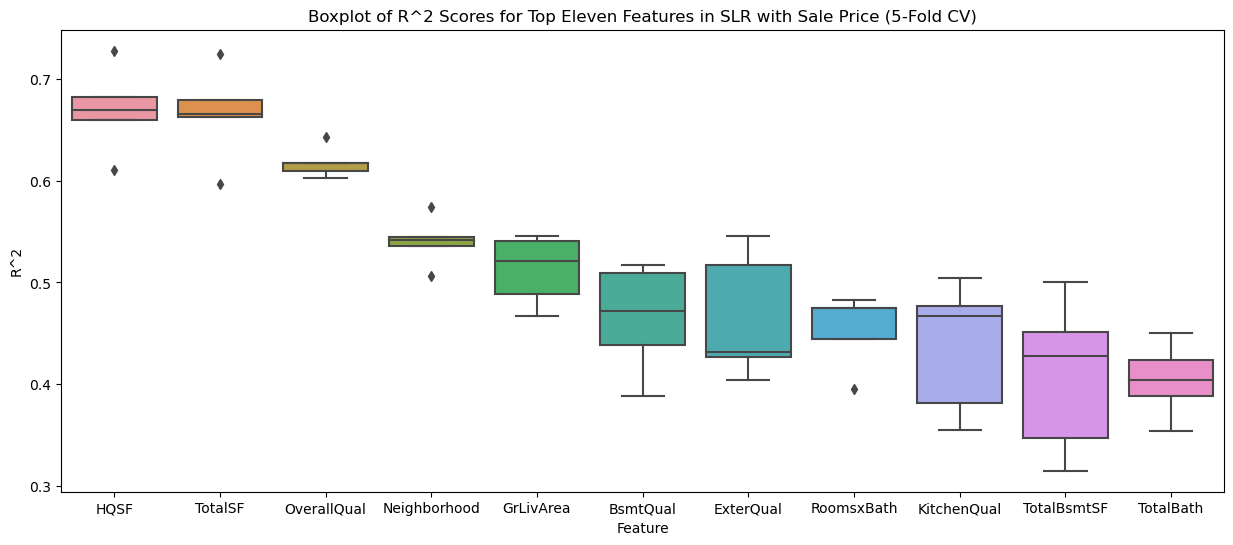

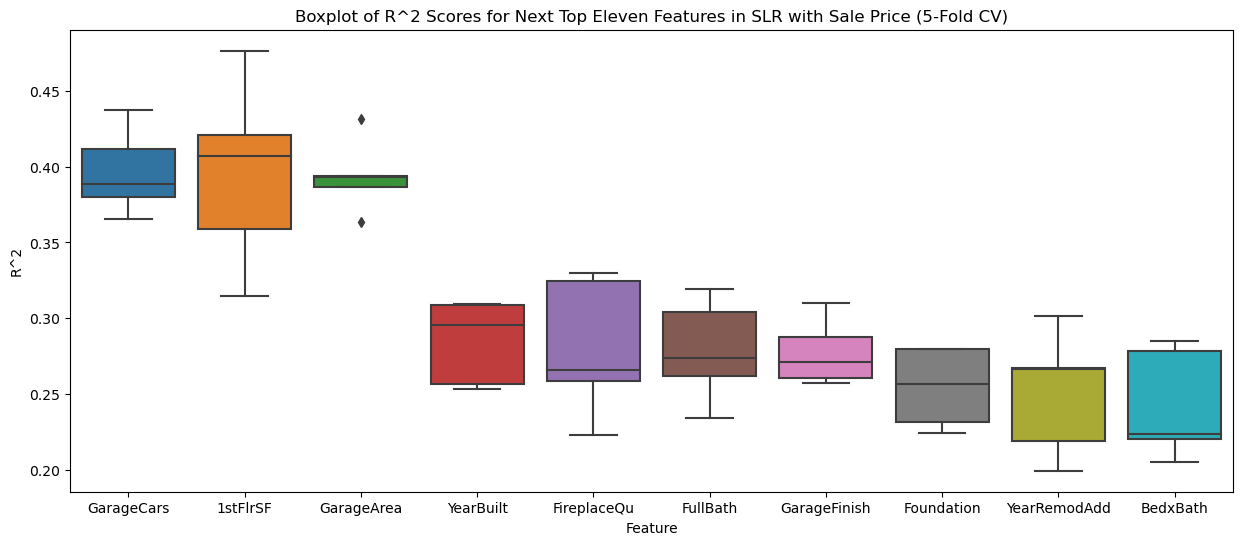

In [156]:
#Plot Results of Top Variables for R2 in box plot

slr_CV_toplot = slr_CV_df.iloc[:11,0:6]
slr_CV_toplot2 = slr_CV_df.iloc[11:21, 0:6]

df_long = slr_CV_toplot.melt(id_vars='Feature', var_name='Fold', value_name='R^2')
df_long2 = slr_CV_toplot2.melt(id_vars='Feature', var_name='Fold', value_name='R^2')

plt.figure(figsize=(15, 6))
sns.boxplot(x='Feature', y='R^2', data=df_long)
plt.title('Boxplot of R^2 Scores for Top Eleven Features in SLR with Sale Price (5-Fold CV)')
plt.xlabel('Feature')
plt.ylabel('R^2')
plt.show()

plt.figure(figsize=(15, 6))
sns.boxplot(x='Feature', y='R^2', data=df_long2)
plt.title('Boxplot of R^2 Scores for Next Top Eleven Features in SLR with Sale Price (5-Fold CV)')
plt.xlabel('Feature')
plt.ylabel('R^2')
plt.show()

# Multiple Linear Regression
With some clear insight through simple linear regression, the next step is multiple linear regression. I want to combine ~6 of these variables and create a model that is reasonably accurate (R^2 > .73) (This basic outline is suggested by De Cock). I want to do this while still remaining as interpretable as possible. Can't just combine the top 6 because of concerns about multicolinearity and categorical variables. Could you stil explain the equation on the back of an envelope?

### III. Sequential Feature Selection:
Rough Overview- powerful, but lacking some interpretability for my "intern's notebook" model.

In [157]:
y = ames['SalePrice']
features = ames.drop(columns = ['PID', 'SalePrice'])
cat_cols = [col for col in features.columns if features[col].dtype == 'object']
cat_features = features.select_dtypes(include=['object'])
cat_features = pd.get_dummies(data = cat_features, drop_first = True)
cat_features = cat_features.replace({False: 0, True: 1})
num_features = features.select_dtypes(include=['int64', 'float64'])
features_dum_drop = pd.concat([cat_features, num_features],axis = 1)
features_dum_drop_noqual = features_dum_drop.drop(columns = ['OverallQual'])

In [158]:
#SFS on ames-> SalePrice
selector = SequentialFeatureSelector(LinearRegression(),
                                         n_features_to_select= 6,
                                         direction='forward',
                                         scoring= 'r2',
                                         cv=5)

In [159]:
selector.fit(features_dum_drop, y)
feature_names = features_dum_drop.columns

selected_features = features_dum_drop.columns[selector.get_support()]
print(selected_features)

selected_features = features_dum_drop.columns[selector.get_support()]

X_selected = features_dum_drop[selected_features]

model = LinearRegression()
scores = cross_val_score(model, X_selected, y, cv=5, scoring='r2')

# Print the R2 scores for each fold
print("R2 scores for each fold: ", scores)

# Print the mean R2 score across all folds
print("Mean R2 score: ", np.mean(scores))

Index(['Neighborhood_NridgHt', 'OverallQual', 'YearRemodAdd', 'BsmtUnfSF',
       'GarageArea', 'HQSF'],
      dtype='object')
R2 scores for each fold:  [0.81649963 0.83687749 0.86485129 0.83852739 0.85312291]
Mean R2 score:  0.841975742159657


In [160]:
y2 = features_dum_drop['OverallQual']

In [160]:
#SFS on ames_noqual --> 'OverallQual'
for x in range(10):
    selector = SequentialFeatureSelector(LinearRegression(),
                                             n_features_to_select= x+1,
                                             direction='forward',
                                             scoring= 'r2',
                                             cv=5
                                            )
    selector.fit(features_dum_drop_noqual, y2)
    feature_names = features_dum_drop.columns

    selected_features = features_dum_drop_noqual.columns[selector.get_support()]
    print(selected_features)

    selected_features = features_dum_drop_noqual.columns[selector.get_support()]

    X_selected = features_dum_drop_noqual[selected_features]

    model = LinearRegression()
    scores = cross_val_score(model, X_selected, y, cv=5, scoring='r2')

    # Print the R2 scores for each fold
    print("R2 scores for each fold: ", scores)

    # Print the mean R2 score across all folds
    print("Mean R2 score: ", np.mean(scores))

Index(['HQSF'], dtype='object')
R2 scores for each fold:  [0.66975642 0.68221338 0.7277198  0.65949258 0.61021271]
Mean R2 score:  0.6698789790090872
Index(['ExterQual_TA', 'HQSF'], dtype='object')
R2 scores for each fold:  [0.7132708  0.73432314 0.76301082 0.73240611 0.70103326]
Mean R2 score:  0.7288088239661291
Index(['ExterQual_TA', 'YearBuilt', 'HQSF'], dtype='object')
R2 scores for each fold:  [0.74147366 0.75719906 0.79610578 0.73986633 0.74037139]
Mean R2 score:  0.7550032450126325
Index(['ExterQual_Fa', 'ExterQual_TA', 'YearBuilt', 'HQSF'], dtype='object')
R2 scores for each fold:  [0.74874035 0.75767138 0.79944489 0.74284817 0.74443765]
Mean R2 score:  0.7586284876896088
Index(['ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'YearBuilt', 'HQSF'], dtype='object')
R2 scores for each fold:  [0.77882311 0.81118802 0.80986288 0.7711973  0.77300795]
Mean R2 score:  0.7888158531194276
Index(['ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'OverallCond',
       'YearBuilt', 'HQSF'],


KeyboardInterrupt: 

'OverallQual' seemingly difficult to recreate with the rest of the dataset! I could imagine someone running a RandomForest here as a way to try to predict OverallQual in order to assess to what extent OverallQual is feature engineering vs. a subjective evaluation that will be hard to replicate for predictive purposes. This seems beyond the scope of this phase of the project.

### IV. MLR continued

In [162]:
#Customizable feature selection for interpretability

def my_mlr(subset_list, df, log = False):
    """ my_mlr function: Reports R^2's from 5-fold CV, Average and Std in a Dataframe
    
        subset_list: list of lists- each element is list of columns you want to include in MLR-
                     dummifies and drops first for categorical variable
        
        df: specify dataframe to use- y will be 'SalePrice'.
        
        log: option to take log transformation of y (slightly improves predictive power, sacrifices interpretability)
    """
    
    y = df['SalePrice']
    
    if log == True:
        y = np.log(df['SalePrice'])
        
    results_list = []

    for subset in subset_list:
        X = df[subset]
        
        cat_cols = [col for col in X.columns if X[col].dtype == 'object']

        if cat_cols:
            encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
            transformed_X = encoder.fit_transform(X[cat_cols])
            transformed_X = pd.DataFrame(transformed_X.toarray(), columns=encoder.get_feature_names_out())
            transformed_X.reset_index(drop=True, inplace=True)  # Reset index
            X.reset_index(drop=True, inplace=True)  # Reset index for X as well
            X = pd.concat([X.drop(columns=cat_cols), transformed_X], axis=1)

        model = LinearRegression()
        cv_scores = cross_val_score(model, X, y, cv=5)

        df_list = [subset] + list(cv_scores) + [np.mean(cv_scores), np.std(cv_scores)]
        results_list.append(df_list)
        
        results_list = sorted(results_list, key = lambda x: x[6], reverse = True)

    CV_df = pd.DataFrame(results_list, columns=['Features'] + [f'Fold{i}' for i in range(1, 6)] + ['Avg', 'Std'])

    return CV_df

With my_mlr, you can run through a bunch of different combinations of variables, any length, and see what
kind of model performance you get. This setup works right now if for categorical variables, every aspect
plays a part. Another argument in the function is for the specified dataframe, so it's possible to experiment with different conditions on the dataset.

In [50]:
#Suggestions from De Cock to improve performance of an MLR model- removes about 165 observations
ames_normal = ames[(ames['SaleCondition'] == 'Normal') & (ames['GrLivArea'] <= 4000)]

#### Experimentation: 
Combining columns that yield high R2 and aren't multicolinear. Shooting for both accuracy and simplicity in a MLR model. HQSF and Neighborhood are two high R2 variables from SLR without being colinear- good base for exploring further variable additions.

In [163]:
#Hold Neighborhood and HQSF as constant
mytestlist = []
for col in ames_normal.columns.tolist():
    subset = [col, 'Neighborhood', 'HQSF']
    if len(set(subset)) == 3:
        mytestlist.append(subset)

x = my_mlr(mytestlist, ames_normal, log = False)
x

,Features,Fold1,Fold2,Fold3,Fold4,Fold5,Avg,Std
0,"[SalePrice, Neighborhood, HQSF]",1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000
1,"[OverallQual, Neighborhood, HQSF]",0.8413,0.8675,0.8463,0.8265,0.8216,0.8407,0.0162
2,"[KitchenQual, Neighborhood, HQSF]",0.8397,0.8732,0.8393,0.8176,0.8102,0.8360,0.0220
3,"[ExterQual, Neighborhood, HQSF]",0.8555,0.8669,0.8330,0.7925,0.8045,0.8305,0.0285
4,"[BsmtUnfSF, Neighborhood, HQSF]",0.8366,0.8604,0.8461,0.7993,0.8010,0.8287,0.0245
5,"[BsmtQual, Neighborhood, HQSF]",0.8431,0.8570,0.8500,0.7925,0.7884,0.8262,0.0295
6,"[BsmtExposure, Neighborhood, HQSF]",0.8475,0.8451,0.8414,0.7881,0.7885,0.8221,0.0277
7,"[OverallCond, Neighborhood, HQSF]",0.8359,0.8465,0.8300,0.7943,0.7811,0.8176,0.0253
8,"[BsmtFinType1, Neighborhood, HQSF]",0.8325,0.8528,0.8416,0.7817,0.7751,0.8167,0.0320
9,"[BsmtFinSF1, Neighborhood, HQSF]",0.8312,0.8514,0.8340,0.7770,0.7840,0.8155,0.0295


In [174]:
#add to 'HQSF' and 'Neighborhood' from SFS->: ames_noqual on 'OverallQual'

proposed_notebook_list = ['Neighborhood', 'HQSF', 'TotalBath', 'BedroomAbvGr', 'FireplaceYN', 'GarageCars']
#'Adding YearBuilt here adds .003 to the R2, perhaps not enough to add for the notebook formula'
#This notebook formula is subjective

modified_sfs_list = [['YearBuilt', 'HQSF', 'Neighborhood'],
             ['ExterQual', 'YearBuilt', 'HQSF', 'Neighborhood'],
             ['OverallCond', 'ExterQual', 'YearBuilt', 'HQSF', 'Neighborhood'],
             ['FireplaceYN', 'OverallCond', 'ExterQual', 'YearBuilt', 'HQSF', 'Neighborhood'],
            #Remember that in the line above, OverallCond is on a scale of 1-10, 
            #and ExterQual is ordinal/categorical in 5 steps.
             
             proposed_notebook_list]


my_mlr(modified_sfs_list, ames_normal, log = False)

,Features,Fold1,Fold2,Fold3,Fold4,Fold5,Avg,Std
0,"[FireplaceYN, OverallCond, ExterQual, YearBuil...",0.8777,0.8872,0.8578,0.8283,0.8429,0.8588,0.0217
1,"[OverallCond, ExterQual, YearBuilt, HQSF, Neig...",0.8759,0.8808,0.8521,0.8207,0.8298,0.8519,0.0240
2,"[ExterQual, YearBuilt, HQSF, Neighborhood]",0.8591,0.8718,0.8374,0.7955,0.8108,0.8349,0.0286
3,"[Neighborhood, HQSF, TotalBath, BedroomAbvGr, ...",0.8412,0.8534,0.8405,0.8091,0.8038,0.8296,0.0195
4,"[YearBuilt, HQSF, Neighborhood]",0.8254,0.8442,0.8258,0.7752,0.7678,0.8077,0.0304


### V. Build 'Notebook Model'- Extract coefficients

In [175]:
def mlr_coefs(subset, df, log = False):
    """ mlr_coefs function: Reports R^2's and RMSE from 5-fold CV, 
    Reports R^2's from 5-fold CV, Average and Std in a Dataframe
    
        subset_list: list of lists- each element is list of columns you want to include in MLR
        df: specify dataframe to use
        log: option to take log transformation of response variable
    """
    rmse_scores = []
    r2_scores = []
    coefs_per_fold = []
    
    all_y_pred = []
    all_y_actual = []
    residuals = []
    
    y = df['SalePrice']
    
    if log == True:
        y = np.log(df['SalePrice'])
    

    results_list = []

    X = df[subset]

    cat_cols = [col for col in X.columns if X[col].dtype == 'object']

    if cat_cols:
        encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
        transformed_X = encoder.fit_transform(X[cat_cols])
        transformed_X = pd.DataFrame(transformed_X.toarray(), columns=encoder.get_feature_names_out())
        transformed_X.reset_index(drop=True, inplace=True)
        X.reset_index(drop=True, inplace=True)
        X = pd.concat([X.drop(columns=cat_cols), transformed_X], axis=1)
   
    kf = KFold(n_splits = 5, shuffle = False)
    
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]        
    
        lm = LinearRegression()
        lm.fit(X_train, y_train)
    
        coefs_per_fold.append(lm.coef_)
    
        y_pred = lm.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        
        all_y_pred.extend(y_pred)
        all_y_actual.extend(y_test.values)
        residuals.extend(y_test.values - y_pred)
        
        print(f"Fold {fold+1}: RMSE = {round(rmse, 4)}, R2 = {round(r2, 4)}")
    
    mean_rmse = np.mean(rmse_scores)
    mean_r2 = np.mean(r2_scores)
    
    print(f"Average RMSE: {round(mean_rmse, 4)}")
    print(f"Std of RMSE: {round(np.std(rmse_scores), 4)}")
    print(f"Average R2: {round(mean_r2, 4)}")
    print(f"Std of R2: {round(np.std(r2_scores), 4)}")

    
    feature_names = X.columns
    coef_df = pd.DataFrame(coefs_per_fold, columns = feature_names)
    coef_df = coef_df.T
    coef_df.columns = [f"Fold {i+1}" for i in range(coef_df.shape[1])]
    coef_df['Std'] = coef_df.std(axis=1)
    coef_df['Avg Coef'] = coef_df[['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']].mean(axis=1)
    return coef_df

In [176]:
x = mlr_coefs(proposed_notebook_list, ames_normal, log = False)
x
#Try with log = True!

Fold 1: RMSE = 29493.1389, R2 = 0.8412
Fold 2: RMSE = 27031.2259, R2 = 0.8534
Fold 3: RMSE = 27529.7029, R2 = 0.8405
Fold 4: RMSE = 29888.6095, R2 = 0.8091
Fold 5: RMSE = 29724.7264, R2 = 0.8038
Average RMSE: 28733.4807
Std of RMSE: 1203.3889
Average R2: 0.8296
Std of R2: 0.0195


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Std,Avg Coef
HQSF,48.9849,51.2474,51.7161,51.9194,53.1672,1.5288,51.4070
TotalBath,11490.0798,11186.1601,11058.3431,10798.2047,10392.1115,414.5357,10984.9798
BedroomAbvGr,-6762.5378,-8235.6128,-8613.7824,-7288.4515,-7443.5141,746.8264,-7668.7797
FireplaceYN,12623.8572,10956.4024,12033.5793,11546.0008,10720.3539,778.5106,11576.0387
GarageCars,11458.8311,12390.8061,11366.0287,11237.7479,10949.5853,543.8358,11480.5998
Neighborhood_Blueste,-976.8252,8368.7839,-4140.0741,5083.1758,5305.9858,5121.2176,2728.2092
Neighborhood_BrDale,-1737.4843,4670.3509,-2853.5255,51.1605,1871.9468,2986.5733,400.4897
Neighborhood_BrkSide,96.9222,6795.0469,2237.6245,2186.1204,4415.0298,2548.0076,3146.1488
Neighborhood_ClearCr,22571.3421,25541.9182,16942.7935,21721.5670,27114.8463,3926.0626,22778.4934
Neighborhood_CollgCr,22216.8071,27359.2932,20492.5706,23331.6372,24569.8065,2584.2789,23594.0229


In [177]:
#Fuller- numeric plus categorical
features = ames_normal[proposed_notebook_list]
target = ames_normal['SalePrice']

In [178]:
features.columns

Index(['Neighborhood', 'HQSF', 'TotalBath', 'BedroomAbvGr', 'FireplaceYN',
       'GarageCars'],
      dtype='object')

In [181]:
# Preprocess features using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['HQSF', 'TotalBath', 'BedroomAbvGr', 'FireplaceYN', 'GarageCars']),
        ('cat', OneHotEncoder(sparse=False, drop=['MeadowV'], handle_unknown='ignore'), ['Neighborhood'])
    ])
# Fit and transform the features
X_transformed = preprocessor.fit_transform(features)
feature_names = ['HQSF', 'TotalBath', 'BedroomAbvGr', 'FireplaceYN', 'GarageCars'] + list(preprocessor.named_transformers_['cat'].get_feature_names_out())

/Users/joesferra/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [182]:
# Initialize KFold
kf = KFold(n_splits=5)
# Initialize variables to store results
coefficients_list = []
intercepts_list = []
scores = []

# Perform the KFold cross-validation
for train_index, test_index in kf.split(X_transformed):
    X_train, X_test = X_transformed[train_index], X_transformed[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    # Initialize the linear regression model
    model = LinearRegression()
    # Fit the model on the training data
    model.fit(X_train, y_train)
    # Store coefficients and intercepts
    coefficients_list.append(model.coef_)
    intercepts_list.append(model.intercept_)
    # Evaluate the model
    scores.append(model.score(X_test, y_test))
# Calculate the mean of scores, coefficients, and intercepts
average_score = np.mean(scores)
average_coefficients = np.mean(coefficients_list, axis=0)
# Display the average R² score across all folds
print(f"Mean CV R² Score of Combined Model: {average_score:.4f}")
mean_intercept = np.mean(intercepts_list)
print(f"Mean Y-intercept = {mean_intercept:.0f}")

Mean CV R² Score of Combined Model: 0.8296
Mean Y-intercept = -2857


In [183]:
# Create a DataFrame for the coefficients
df_coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Average Coefficient': average_coefficients
    }).sort_values(by='Average Coefficient').reset_index(drop=True)
# Display the DataFrame
print("Coefficients for Combined Model:")
print(df_coefficients)

Coefficients for Combined Model:
                 Feature  Average Coefficient
0           BedroomAbvGr           -7668.7797
1   Neighborhood_NPkVill           -3166.9159
2                   HQSF              51.4070
3     Neighborhood_SWISU             303.9659
4   Neighborhood_OldTown            1226.5066
5    Neighborhood_IDOTRR            5906.8021
6   Neighborhood_Edwards            8514.2180
7   Neighborhood_Blmngtn            8944.3533
8    Neighborhood_BrDale            9344.8430
9   Neighborhood_Landmrk            9572.1982
10    Neighborhood_NAmes            9799.9396
11             TotalBath           10984.9798
12   Neighborhood_NWAmes           11187.9286
13            GarageCars           11480.5998
14           FireplaceYN           11576.0387
15  Neighborhood_Blueste           11672.5626
16   Neighborhood_Sawyer           12020.4931
17  Neighborhood_BrkSide           12090.5021
18  Neighborhood_Mitchel           15535.6278
19  Neighborhood_SawyerW           20930.3032
2

### VI. "Back of the Envelope" Multiple Linear Regression Model: 
With a success rate of about 83%, we can characterize the pricing of homes in Ames between 2006-2010 with a multiple linear regression model written as:

$$
SalePrice = -2857 + Neighborhood + 51.4HQSF + 10984.98TotalBath + -7668.78BedroomAbvGr + 11576.04FireplaceYN(0/1) + 11480.6GarageCars
$$

Substitute the corresponding coefficient for Neighborhood (If in MeadwV, substitute 0.) First ordered by coefficients, then alphabetized by neighborhood name.

In [107]:
pd.options.display.float_format = '{:.2f}'.format
filtered_df = df_coefficients[df_coefficients['Feature'].str.startswith('Ne')]
new_row = {'Feature': 'Neighborhood_MeadowV', 'Average Coefficient': 0}
new_row_df = pd.DataFrame([new_row])
filtered_df = pd.concat([new_row_df, filtered_df], ignore_index=True)
filtered_df['Feature'] = filtered_df['Feature'].str.replace('Neighborhood_', '', regex=False)

filtered_df['Average Coefficient'] = filtered_df['Average Coefficient'].round(2)
print(filtered_df)

    Feature  Average Coefficient
0   MeadowV                 0.00
1   NPkVill             -3166.92
2     SWISU               303.97
3   OldTown              1226.51
4    IDOTRR              5906.80
5   Edwards              8514.22
6   Blmngtn              8944.35
7    BrDale              9344.84
8   Landmrk              9572.20
9     NAmes              9799.94
10   NWAmes             11187.93
11  Blueste             11672.56
12   Sawyer             12020.49
13  BrkSide             12090.50
14  Mitchel             15535.63
15  SawyerW             20930.30
16  Gilbert             25799.80
17   Greens             30218.39
18  ClearCr             31722.85
19  CollgCr             32538.38
20  Crawfor             36654.95
21   Timber             43409.66
22  Veenker             43784.03
23  Somerst             45253.80
24  StoneBr             63199.01
25  NoRidge             74610.29
26  NridgHt             75636.74
27  GrnHill            141524.25


In [108]:
alphabetized = filtered_df.sort_values(by='Feature')
alphabetized = alphabetized.reset_index(drop=True)
alphabetized

,Feature,Average Coefficient
0,Blmngtn,8944.35
1,Blueste,11672.56
2,BrDale,9344.84
3,BrkSide,12090.50
4,ClearCr,31722.85
5,CollgCr,32538.38
6,Crawfor,36654.95
7,Edwards,8514.22
8,Gilbert,25799.80
9,Greens,30218.39


### VII. MLR Model Closer Look: StatsModels, VIF, Residuals
StatsModels doesn't support cross-validation, so running the data will either yield inconsistent coefficients and orderings by way of the train-test split, or an inflation of performance through overfitting. This can give us an impression, though of which variables will be the most reliable. For neighborhoods with p-values of .05 or higher, we could hope to add more sales later to make their sample sizes more robust.

We also have an understanding from a breakdown like this that the sample sizes vary wildly between neighborhoods, and we will likely get some big p-values in the Neighborhood breakdown.

In [237]:
neighbor_stats = ames_normal.groupby('Neighborhood')['SalePrice'].agg(['count', 'mean']).sort_values(by='mean')
print(neighbor_stats.round(0).astype(int))

              count    mean
Neighborhood               
MeadowV          34   96836
BrDale           26  107360
IDOTRR           68  111615
BrkSide          98  126674
OldTown         204  127898
Edwards         155  131223
SWISU            40  132519
Landmrk           1  137000
Sawyer          135  137190
NPkVill          22  140743
Blueste          10  143590
NAmes           395  145778
Mitchel         101  163818
SawyerW         106  187753
Gilbert         130  188606
NWAmes          117  192515
Greens            8  193531
Blmngtn          19  195853
CollgCr         226  196502
Crawfor          89  199951
ClearCr          38  216559
Somerst         114  223900
Timber           52  241773
Veenker          22  255866
StoneBr          35  276269
GrnHill           2  280000
NridgHt         100  302479
NoRidge          66  319616


In [239]:
x = sm.add_constant(X_transformed)
y = target
model= sm.OLS(y, x)
results = model.fit()
results.model.data.xnames = ['const'] + feature_names
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     379.9
Date:                Tue, 11 Jun 2024   Prob (F-statistic):               0.00
Time:                        13:58:56   Log-Likelihood:                -28160.
No. Observations:                2413   AIC:                         5.639e+04
Df Residuals:                    2380   BIC:                         5.658e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -2866.5929 

In [184]:
x = ['Neighborhood', 'HQSF', 'TotalBath', 'BedroomAbvGr', 'FireplaceYN', 'GarageCars']
vif_check = ames_normal[['Neighborhood', 'HQSF', 'TotalBath', 'BedroomAbvGr', 'FireplaceYN', 'GarageCars']]

vif_check_encoded = pd.get_dummies(vif_check, columns = ['Neighborhood'], drop_first=True)
vif_check_encoded = vif_check_encoded.replace({False: 0, True: 1})

vif_data = pd.DataFrame()
vif_data["feature"] = vif_check_encoded.columns

vif_data["VIF"] = [variance_inflation_factor(vif_check_encoded.values, i) for i in range(vif_check_encoded.shape[1])]

vif_data

,feature,VIF
0,HQSF,33.9646
1,TotalBath,17.6281
2,BedroomAbvGr,19.7390
3,FireplaceYN,2.9851
4,GarageCars,11.8975
5,Neighborhood_Blueste,1.0673
6,Neighborhood_BrDale,1.1599
7,Neighborhood_BrkSide,1.5893
8,Neighborhood_ClearCr,1.4104
9,Neighborhood_CollgCr,3.3539


#### Plot Residuals

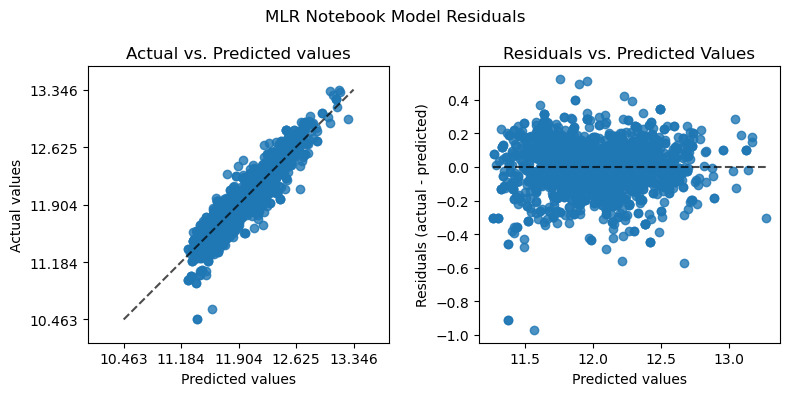

In [189]:
lr = LinearRegression()
y = ames_normal['SalePrice']
y_pred = cross_val_predict(lr, X_transformed,
                           y, cv=5)

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    subsample=2000,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    subsample=2000,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("MLR Notebook Model Residuals")
plt.tight_layout()
plt.show()

In [186]:
results_dict = {'Model': ['MLR: Notebook'], 
     'Columns': [['Neighborhood', 'HQSF', 'TotalBath', 'BedroomAbvGr', 'FireplaceYN', 'GarageCars']],
    'Mean R2': .8296,
    'Std R2': .0195,            
    'Mean RMSE': 28733.48,
    'Std RMSE': 1203.39}
mlr_df = pd.DataFrame(data=results_dict)
mlr_df

,Model,Columns,Mean R2,Std R2,Mean RMSE,Std RMSE
0,MLR: Notebook,"[Neighborhood, HQSF, TotalBath, BedroomAbvGr, ...",0.8296,0.0195,28733.4800,1203.3900


In [187]:
output_file = 'master_scores_MLR.csv'

mlr_df.to_csv(output_file, index=False, mode='w')

print(f"DataFrame exported to '{output_file}' in the same working directory.")

DataFrame exported to 'master_scores_MLR.csv' in the same working directory.
